### General Structure

* Pynoddy Model created automatically from Pynoddy Priors
* Value Extractions from Pynoddy Model and insertion into GeMpy Model in convenient format
* GeMpy Model created automatically from GeMpy Priors and Pynoddy Extracts

# Import

TODO: 
* clean up this mess

In [2]:
import sys
import os
sys.path.append("C:/Users/lebobcrash/Documents/GitHub/pygeomod/pygeomod")
sys.path.append("../pygeomod/pygeomod")
sys.path.append("C:/Users/lebobcrash/Documents/GitHub/GeMpy/GeMpy")
sys.path.append("../GeMpy/GeMpy")
sys.path.append("C:/Users/lebobcrash/Documents/GitHub/pynoddy/")
sys.path.append("../pynoddy")
sys.path.append("..")
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import axes3d
import matplotlib
import matplotlib.cm as cm
from skimage import measure
import theano.tensor as T
import GeoMig
reload(GeoMig)
import PosteriorAnalysis as pa
from PosteriorAnalysis import Utility
reload(Utility)
import pynoddy.history
import pynoddy.output
import pynoddy.experiment
import pymc
import pandas as pn
import matplotlib as mpl
import pymc
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
np.set_printoptions(precision = 6, linewidth= 130, suppress =  True)
import pickle
%matplotlib inline
plt.style.use("seaborn-colorblind")

# 0 - Globals

In [3]:
cs = 10.  # cube size
initial_history = "init.his"

## 0.1 - Initialize GeMpy Model

In [4]:
GM = GeoMig.Interpolator(0,200,
                         0,10,
                         0,100,
                         u_grade=3)

GM.set_resolutions(200,4,100) # set grid resolution
GM.create_regular_grid_3D()
GM.theano_compilation_3D() # compile

C:\Users\lebobcrash\Anaconda2\lib\site-packages\ipykernel\__main__.py:8: DeprecationWarning: stack(*tensors) interface is deprecated, use stack(tensors, axis=0) instead.


# 1 -  Priors

TODO:
* Flexible, automated addition of pymc.Distribution objects

## 1.1 - Pynoddy Priors

In [5]:
pynoddy_prior_dict = Utility.load_priors("PGM2_pynoddy_priors.json")  # load prior json file dictionary
for key in pynoddy_prior_dict.keys():  # add pymc distributions based on values
    print key
    pynoddy_prior_dict[key]["pymc"] = pymc.Normal(str(key), pynoddy_prior_dict[key]["mean"], 1./np.square(pynoddy_prior_dict[key]["stdev"]))

Layer3_Height
Unconformity_Rotation
Layer2_Height
Fold_Amplitude
Stratigraphy_Rotation
Fold_Wavelength
Unconformity_Z


## 1.2 - GeMpy Priors

In [8]:
gempy_mean_prior_interfaces = np.load("mean_prior_interfaces.npy")
gempy_mean_prior_interfaces = np.c_[gempy_mean_prior_interfaces, np.array([pymc.Normal(row[3]+"_x"+str(row[0])+"_y"+str(row[1]), row[2], 1./np.square(row[2]/10.)) for row in gempy_mean_prior_interfaces])]
gempy_mean_prior_interfaces = gempy_mean_prior_interfaces[gempy_mean_prior_interfaces[:,3]!="Layer5"]
gempy_mean_prior_interfaces

array([[20, 0, 54, 'Layer1', <pymc.distributions.Normal 'Layer1_x20_y0' at 0x0000000011899EB8>],
       [20, 0, 42, 'Layer2', <pymc.distributions.Normal 'Layer2_x20_y0' at 0x00000000118997B8>],
       [20, 0, 22, 'Layer3', <pymc.distributions.Normal 'Layer3_x20_y0' at 0x0000000011899898>],
       [110, 0, 61, 'Layer3', <pymc.distributions.Normal 'Layer3_x110_y0' at 0x00000000118A5748>],
       [170, 0, 49, 'Layer1', <pymc.distributions.Normal 'Layer1_x170_y0' at 0x00000000124D69E8>],
       [170, 0, 37, 'Layer2', <pymc.distributions.Normal 'Layer2_x170_y0' at 0x00000000124D6390>],
       [170, 0, 17, 'Layer3', <pymc.distributions.Normal 'Layer3_x170_y0' at 0x00000000124D65C0>]], dtype=object)

In [9]:
interf = pn.DataFrame(columns=["X", "Y", "Z", "formation"])
for row in gempy_mean_prior_interfaces:
    interf.loc[len(interf)] = [row[0], row[1], row[2], row[3]]
    
GM.load_data_pd("interfaces", interf)

# 2 - Pynoddy Model

In [10]:
pymc_ex = pynoddy.experiment.Experiment(initial_history)

@pymc.deterministic
def pynoddy_model(value=0, 
                  prior_dict=pynoddy_prior_dict,  # dictionary of prior value distributions
                  ex=pymc_ex, # the pynoddy experiment object
                  cs=cs, # experiment cube size
                  topology=True,
                  name = "pynoddy_model_temp",
                  verbose = 0
                 ):
    """
    Creates Pynoddy Model Output from Pynoddy Prior Parameter distribution dictionary 
    with topology output and returns block model.
    """
    Utility.pynoddy_assign_priors(prior_dict, ex)  # assign priors to respective event properties
    if topology:
        ex.write_history(name+".his")  # write history of modified experiment
        pynoddy.compute_model(name+".his", name+"_out", sim_type="TOPOLOGY")  # compute model with files necessary for 
                                                                              # topology analysis
        model = pynoddy.output.NoddyOutput(name+"_out")  # load model output file in order to return it
        
        if verbose > 0:
            plt.imshow(model.block[:,0,:].T, origin="lower", cmap="YlOrRd")
    
    return model.block[:,:,:]  # return model

## 2.1 - Pynoddy Topology

In [11]:
@pymc.deterministic
def pynoddy_topology(value=0, 
                     pynoddy_model=pynoddy_model, 
                     name = "pynoddy_model_temp"
                    ):
    """Computes topology of pynoddy model output file and returns topology object for further analysis."""
    pynoddy.compute_topology(name+"_out", topology_path="topology.exe", type="TOPOLOGY");  # compute topology
    topology = pynoddy.output.NoddyTopology(name+"_out")  # load computed topology output
    return topology  #return topology object

## 2.2 - Pynoddy Extraction

What needs extraction? Only Unconformity layer and additional to that maybe the upper layer? In order to avoid shit like the weirdly bent unconformity interface of PGM2_5 - could serve as a nice visual cue of the advantages of this model type.

In [13]:
@pymc.deterministic
def pynoddy_extraction(value=0,
                       pynoddy_model=pynoddy_model,
                       x_pos = [5,50,90,150,180],
                       y_pos = [0],
                       layers = [5,1],
                       verbose=0
                      ):
    
    extracted_lh = Utility.noddy_extract_lh(pynoddy_model, x_pos, y_pos, layers)
    interf = pn.DataFrame(columns=["X", "Y", "Z", "formation"])
    for row in extracted_lh:
        interf.loc[len(interf)] = [row[0], row[1], row[2], row[3]]
    
    if verbose == 1:
        print interf
    if verbose > 0:
        plt.imshow(pynoddy_model[:,0,:].T, origin="lower", cmap="YlOrRd")
        plt.scatter(interf["X"], interf["Z"], label="Interfaces")
        
    return interf

# 3 - GeMpy Model

In [14]:
@pymc.deterministic
def gempy_model(value=0,
                pynoddy_extracts=pynoddy_extraction,
                priors=gempy_mean_prior_interfaces,
                verbose=0,
               ):
    
    # set prior interface values
    interf = pn.DataFrame(columns=["X", "Y", "Z", "formation"])
    for row in priors:
        interf.loc[len(interf)] = [row[0], row[1], row[2], row[3]]

    interf["Z"] = priors[:,4]
    interf = interf.append(pynoddy_extracts, ignore_index=True)
    GM.load_data_pd("interfaces", interf)
    
    if verbose == 1:
        print GM.Interfaces
    
    GM.load_data_pd("foliations", Utility.calc_fucking_foliations(GM.Interfaces))
    
    if verbose == 1:
        print GM.Foliations
    
    
    
    # load layers into series
    initial = []
    for layer in GM.formations:
        if layer != "Layer5":
            initial.append(layer)
    GM.set_series({"Initial": tuple(initial), "Unconformity": "Layer5"})
    
    if verbose==1:
        print GM.series
    
    if len(GM.Interfaces["formation"][GM.Interfaces["formation"]=="Layer5"]) == 0:
        return np.ndarray((200,100))
    else:
        try:
            # gempy magic calculation

            GM.block.set_value(np.zeros_like(GM.grid[:,0]))

            GM.compute_block_model([0,1],verbose = 0)


            plot_block =  GM.block.get_value().reshape(200,4,100)

            if verbose > 0:
                plt.imshow(plot_block[:,2,:].T, origin="lower")
                plt.plot(GM.Interfaces["X"],GM.Interfaces["Z"],"o")
                plt.plot(GM.Foliations["X"],GM.Foliations["Z"],"x", color="red")
                plt.xlim(0,200)
                plt.ylim(0,100)

            return plot_block[:,2,:] # return gempy block model
        except:
            return np.ndarray((200,100))

# 4 - Likelihoods
## 4.1 - Topology Likelihood (Unconformity Connectivity)

In [15]:
@pymc.stochastic
def like_topology_003_005(value=0, topology=pynoddy_topology):
    # check adjacency
    adj = Utility.check_adjacency("003", "005", topology)
    return pymc.bernoulli_like(adj,0.01) # use bernoulli likelihood, probabilitiy of sucess (adj==True) of 0.01
                                         # ergo making it highly unlikely that the two layers are somehow connected

## 4.2 - GeMpy Likelihoods (Layer Interface Heights)

In [20]:
like_layer_heights = pickle.load(open("like_layer_heights2.p", "rb" ))

In [21]:
# layer 1
#@pymc.stochastic
#def like_xpos0_layer_1(value=0, gempy_model=gempy_model, like_layer_heights=like_layer_heights):
#    x_pos=np.sort(like_layer_heights.keys())
#    if 1.0 in gempy_model[x_pos[0],:]:
#        model_height = np.where(gempy_model[x_pos[0],:]==1.0)[0][0]
#        return np.log(like_layer_heights[x_pos[0]][1].evaluate(model_height))[0]
#    else:
#        return np.log(0.001)

#@pymc.stochastic
#def like_xpos1_layer_1(value=0, gempy_model=gempy_model, like_layer_heights=like_layer_heights):
#    x_pos=np.sort(like_layer_heights.keys())
#    if 1.0 in gempy_model[x_pos[1],:]:
#        model_height = np.where(gempy_model[x_pos[1],:]==1.0)[0][0]
#        return np.log(like_layer_heights[x_pos[1]][1].evaluate(model_height))[0]
#    else:
#        return np.log(0.001)
    
#@pymc.stochastic
#def like_xpos2_layer_1(value=0, gempy_model=gempy_model, like_layer_heights=like_layer_heights):
#    x_pos=np.sort(like_layer_heights.keys())
#    if 1.0 in gempy_model[x_pos[2],:]:
#        model_height = np.where(gempy_model[x_pos[2],:]==1.0)[0][0]
#        return np.log(like_layer_heights[x_pos[2]][1].evaluate(model_height))[0]
#    else:
#        return np.log(0.001)
    
#@pymc.stochastic
#def like_xpos3_layer_1(value=0, gempy_model=gempy_model, like_layer_heights=like_layer_heights):
#    x_pos=np.sort(like_layer_heights.keys())
#    if 1.0 in gempy_model[x_pos[3],:]:
#        model_height = np.where(gempy_model[x_pos[3],:]==1.0)[0][0]
#        return np.log(like_layer_heights[x_pos[3]][1].evaluate(model_height))[0]
#    else:
#        return np.log(0.001)
#
#@pymc.stochastic
#def like_xpos4_layer_1(value=0, gempy_model=gempy_model, like_layer_heights=like_layer_heights):
#    x_pos=np.sort(like_layer_heights.keys())
#    if 1.0 in gempy_model[x_pos[4],:]:
#        model_height = np.where(gempy_model[x_pos[4],:]==1.0)[0][0]
#        return np.log(like_layer_heights[x_pos[4]][1].evaluate(model_height))[0]
#    else:
#        return np.log(0.001)
#    
# -----------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------
# layer 2
@pymc.stochastic
def like_xpos0_layer_2(value=0, gempy_model=gempy_model, like_layer_heights=like_layer_heights):
    x_pos=np.sort(like_layer_heights.keys())
    if 2.0 in gempy_model[x_pos[0],:]:
        model_height = np.where(gempy_model[x_pos[0],:]==2.0)[0][0]
        return np.log(like_layer_heights[x_pos[0]][2].evaluate(model_height))[0]
    else:
        return np.log(0.001)

@pymc.stochastic
def like_xpos1_layer_2(value=0, gempy_model=gempy_model, like_layer_heights=like_layer_heights):
    x_pos=np.sort(like_layer_heights.keys())
    if 2.0 in gempy_model[x_pos[1],:]:
        model_height = np.where(gempy_model[x_pos[1],:]==2.0)[0][0]
        return np.log(like_layer_heights[x_pos[1]][2].evaluate(model_height))[0]
    else:
        return np.log(0.001)
    
@pymc.stochastic
def like_xpos2_layer_2(value=0, gempy_model=gempy_model, like_layer_heights=like_layer_heights):
    x_pos=np.sort(like_layer_heights.keys())
    if 2.0 in gempy_model[x_pos[2],:]:
        model_height = np.where(gempy_model[x_pos[2],:]==2.0)[0][0]
        return np.log(like_layer_heights[x_pos[2]][2].evaluate(model_height))[0]
    else:
        return np.log(0.001)
    
@pymc.stochastic
def like_xpos3_layer_2(value=0, gempy_model=gempy_model, like_layer_heights=like_layer_heights):
    x_pos=np.sort(like_layer_heights.keys())
    if 2.0 in gempy_model[x_pos[3],:]:
        model_height = np.where(gempy_model[x_pos[3],:]==2.0)[0][0]
        return np.log(like_layer_heights[x_pos[3]][2].evaluate(model_height))[0]
    else:
        return np.log(0.001)
    
@pymc.stochastic
def like_xpos4_layer_2(value=0, gempy_model=gempy_model, like_layer_heights=like_layer_heights):
    x_pos=np.sort(like_layer_heights.keys())
    if 2.0 in gempy_model[x_pos[4],:]:
        model_height = np.where(gempy_model[x_pos[4],:]==2.0)[0][0]
        return np.log(like_layer_heights[x_pos[4]][2].evaluate(model_height))[0]
    else:
        return np.log(0.001)
    
# -----------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------
# layer 3
@pymc.stochastic
def like_xpos0_layer_3(value=0, gempy_model=gempy_model, like_layer_heights=like_layer_heights):
    x_pos=np.sort(like_layer_heights.keys())
    if 3.0 in gempy_model[x_pos[0],:]:
        model_height = np.where(gempy_model[x_pos[0],:]==3.0)[0][0]
        return np.log(like_layer_heights[x_pos[0]][3].evaluate(model_height))[0]
    else:
        return np.log(0.001)

@pymc.stochastic
def like_xpos1_layer_3(value=0, gempy_model=gempy_model, like_layer_heights=like_layer_heights):
    x_pos=np.sort(like_layer_heights.keys())
    if 3.0 in gempy_model[x_pos[1],:]:
        model_height = np.where(gempy_model[x_pos[1],:]==3.0)[0][0]
        return np.log(like_layer_heights[x_pos[1]][3].evaluate(model_height))[0]
    else:
        return np.log(0.001)
    
@pymc.stochastic
def like_xpos2_layer_3(value=0, gempy_model=gempy_model, like_layer_heights=like_layer_heights):
    x_pos=np.sort(like_layer_heights.keys())
    if 3.0 in gempy_model[x_pos[2],:]:
        model_height = np.where(gempy_model[x_pos[2],:]==3.0)[0][0]
        return np.log(like_layer_heights[x_pos[2]][3].evaluate(model_height))[0]
    else:
        return np.log(0.001)

@pymc.stochastic
def like_xpos3_layer_3(value=0, gempy_model=gempy_model, like_layer_heights=like_layer_heights):
    x_pos=np.sort(like_layer_heights.keys())
    if 3.0 in gempy_model[x_pos[3],:]:
        model_height = np.where(gempy_model[x_pos[3],:]==3.0)[0][0]
        return np.log(like_layer_heights[x_pos[3]][3].evaluate(model_height))[0]
    else:
        return np.log(0.001)
    
@pymc.stochastic
def like_xpos4_layer_3(value=0, gempy_model=gempy_model, like_layer_heights=like_layer_heights):
    x_pos=np.sort(like_layer_heights.keys())
    if 3.0 in gempy_model[x_pos[4],:]:
        model_height = np.where(gempy_model[x_pos[4],:]==3.0)[0][0]
        return np.log(like_layer_heights[x_pos[4]][3].evaluate(model_height))[0]
    else:
        return np.log(0.001)

# -----------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------
# layer 5
#@pymc.stochastic
#def like_xpos0_layer_5(value=0, gempy_model=gempy_model, like_layer_heights=like_layer_heights):
#    x_pos=np.sort(like_layer_heights.keys())
#    if 4.0 in gempy_model[x_pos[0],:]:
#        model_height = np.where(gempy_model[x_pos[0],:]==4.0)[0][0]
#        return np.log(like_layer_heights[x_pos[0]][5].evaluate(model_height))[0]
#    else:
#        return np.log(0.001)
#
#@pymc.stochastic
#def like_xpos1_layer_5(value=0, gempy_model=gempy_model, like_layer_heights=like_layer_heights):
#    x_pos=np.sort(like_layer_heights.keys())
#    if 4.0 in gempy_model[x_pos[1],:]:
#        model_height = np.where(gempy_model[x_pos[1],:]==4.0)[0][0]
#        return np.log(like_layer_heights[x_pos[1]][5].evaluate(model_height))[0]
#    else:
#        return np.log(0.001)
#    
#@pymc.stochastic
#def like_xpos2_layer_5(value=0, gempy_model=gempy_model, like_layer_heights=like_layer_heights):
#    x_pos=np.sort(like_layer_heights.keys())
#    if 4.0 in gempy_model[x_pos[2],:]:
#        model_height = np.where(gempy_model[x_pos[2],:]==4.0)[0][0]
#        return np.log(like_layer_heights[x_pos[2]][5].evaluate(model_height))[0]
#    else:
#        return np.log(0.001)
#
#@pymc.stochastic
#def like_xpos3_layer_5(value=0, gempy_model=gempy_model, like_layer_heights=like_layer_heights):
#    x_pos=np.sort(like_layer_heights.keys())
#    if 4.0 in gempy_model[x_pos[3],:]:
#        model_height = np.where(gempy_model[x_pos[3],:]==4.0)[0][0]
#        return np.log(like_layer_heights[x_pos[3]][5].evaluate(model_height))[0]
#    else:
#        return np.log(0.001)
#    
#@pymc.stochastic
#def like_xpos4_layer_5(value=0, gempy_model=gempy_model, like_layer_heights=like_layer_heights):
#    x_pos=np.sort(like_layer_heights.keys())
#    if 4.0 in gempy_model[x_pos[4],:]:
#        model_height = np.where(gempy_model[x_pos[4],:]==4.0)[0][0]
#        return np.log(like_layer_heights[x_pos[4]][5].evaluate(model_height))[0]
#    else:
#        return np.log(0.001)

# 5 - PYMC Model

In [23]:
like_list = [like_topology_003_005,
             like_xpos0_layer_2,like_xpos1_layer_2,like_xpos2_layer_2,like_xpos3_layer_2,like_xpos4_layer_2,
             like_xpos0_layer_3,like_xpos1_layer_3,like_xpos2_layer_3,like_xpos3_layer_3,like_xpos4_layer_3
            ]

In [24]:
# create model parameter list "params" of stochastic (priors and likelihoods) and deterministic functions used
params = [gempy_mean_prior_interfaces[i,4] for i in range(len(gempy_mean_prior_interfaces[:,4]))]
for key in pynoddy_prior_dict:
    params.append(pynoddy_prior_dict[key]["pymc"])
params.append(gempy_model)
params.append(pynoddy_model)
params.append(pynoddy_topology)
params.append(pynoddy_extraction)

for entry in like_list:
    params.append(entry)
    
model = pymc.Model(params)

# 6 - Run! Run! WAAAARGH!!! RUN YOU PIECE OF SH**!!!

In [25]:
RUN = pymc.MCMC(model, db="hdf5", name="PGM3_run2")
RUN.sample(iter=5000)

 [-----------------100%-----------------] 5001 of 5000 complete in 88838.5 sec

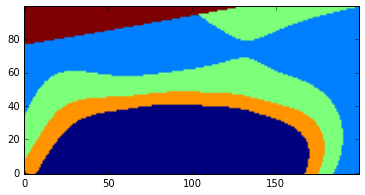

In [23]:
plt.imshow(RUN.trace("gempy_model")[9].T, origin="lower")

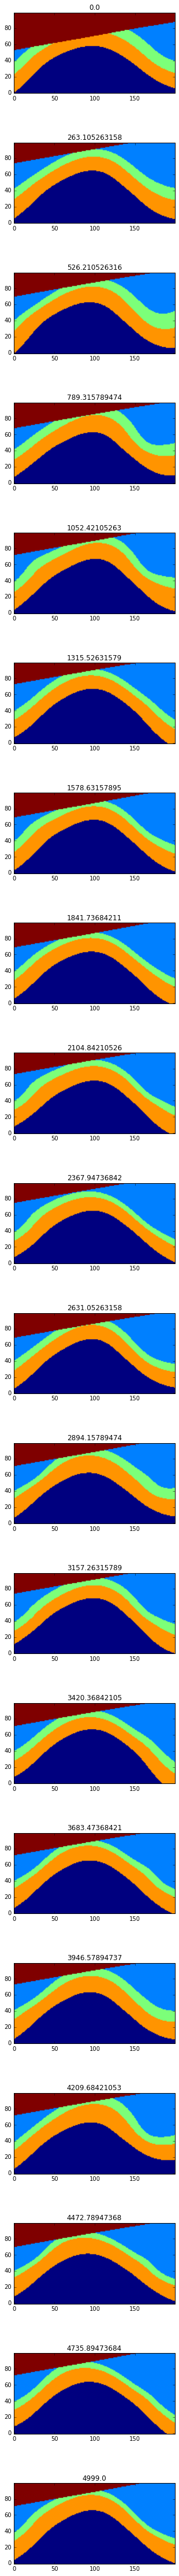

In [26]:
fig, ax = plt.subplots(nrows=20,ncols=1, figsize=(5,20*4))

for row,i in enumerate(np.linspace(0,4999,20)):
    ax[row].imshow(RUN.trace("gempy_model")[i].T, origin="lower")
    ax[row].set_title(str(i))